In [3]:
import pandas as pd

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import pickle

from sklearn.metrics import mean_squared_error

In [5]:
pd.__version__

'1.4.2'

In [6]:
!pip install pyarrow

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet')

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [9]:
import sklearn

In [10]:
sklearn.__version__

'1.0.2'

In [63]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    #In case it is not normalized 
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) 

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td:  td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']

    df[categorical].astype(str)
    return df 

df_train = read_dataframe('./data/green_tripdata_2025-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2025-02.parquet')

In [46]:
len(df_train), len(df_val)

(46307, 44218)

In [12]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0


In [13]:
#Do some filtering 
#df= df[df.trip_type == 2]

In [14]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0


In [15]:
#In case it is not normalized 
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [16]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td:  td.total_seconds() / 60)

In [17]:
df
#duration of the trip in minutes 

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48321,2,2025-01-31 19:36:00,2025-01-31 20:05:00,None,NaN,179,132,NaN,13.99,55.61,...,11.42,0.00,NaN,1.0,68.53,NaN,NaN,NaN,NaN,29.000000
48322,2,2025-01-31 20:33:00,2025-01-31 20:41:00,None,NaN,166,75,NaN,1.51,13.58,...,2.26,0.00,NaN,1.0,17.34,NaN,NaN,NaN,NaN,8.000000
48323,2,2025-01-31 21:09:00,2025-01-31 21:30:00,None,NaN,41,42,NaN,2.90,30.89,...,0.00,0.00,NaN,1.0,32.39,NaN,NaN,NaN,NaN,21.000000
48324,2,2025-01-31 22:22:00,2025-01-31 22:25:00,None,NaN,75,43,NaN,0.34,14.78,...,2.44,0.00,NaN,1.0,18.72,NaN,NaN,NaN,NaN,3.000000


/home/codespace/anaconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

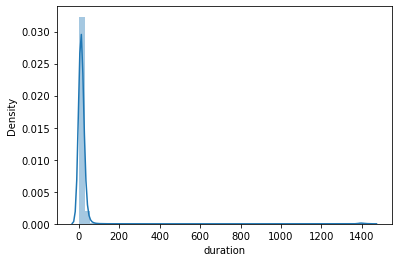

In [18]:
sns.distplot(df.duration)

In [19]:
df.duration.describe(percentiles=[0.95, 0.98,0.99])

count    48326.000000
mean        19.955195
std         93.924039
min          0.000000
50%         11.250000
95%         32.366667
98%         44.983333
99%         61.991667
max       1439.650000
Name: duration, dtype: float64

In [20]:
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9582212473616687

In [21]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [22]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48321,2,2025-01-31 19:36:00,2025-01-31 20:05:00,None,NaN,179,132,NaN,13.99,55.61,...,11.42,0.00,NaN,1.0,68.53,NaN,NaN,NaN,NaN,29.000000
48322,2,2025-01-31 20:33:00,2025-01-31 20:41:00,None,NaN,166,75,NaN,1.51,13.58,...,2.26,0.00,NaN,1.0,17.34,NaN,NaN,NaN,NaN,8.000000
48323,2,2025-01-31 21:09:00,2025-01-31 21:30:00,None,NaN,41,42,NaN,2.90,30.89,...,0.00,0.00,NaN,1.0,32.39,NaN,NaN,NaN,NaN,21.000000
48324,2,2025-01-31 22:22:00,2025-01-31 22:25:00,None,NaN,75,43,NaN,0.34,14.78,...,2.44,0.00,NaN,1.0,18.72,NaN,NaN,NaN,NaN,3.000000


In [69]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [72]:
df_val[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

In [66]:
df[categorical].astype(str)

,PULocationID,DOLocationID
0,75,235
1,166,75
2,171,73
3,74,223
4,66,158
...,...,...
48321,179,132
48322,166,75
48323,41,42
48324,75,43


In [26]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [27]:
dv  = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [28]:
X_train

<46307x3 sparse matrix of type '<class 'numpy.float64'>'
	with 138921 stored elements in Compressed Sparse Row format>

In [29]:
#This is our one hot encoding 
#For each location we have a picture 
dv.feature_names_

['DOLocationID', 'PULocationID', 'trip_distance']

In [30]:
target = 'duration' 
y_train = df[target].values

In [76]:
y_train

array([14.18333333,  5.88333333,  1.86666667, ..., 21.        ,
        3.        ,  7.        ])

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_predict = lr.predict(X_train)

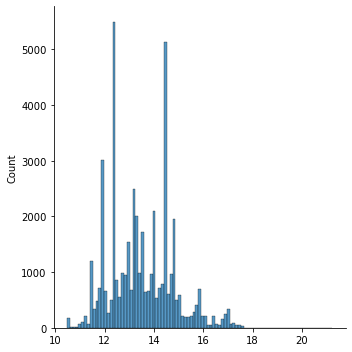

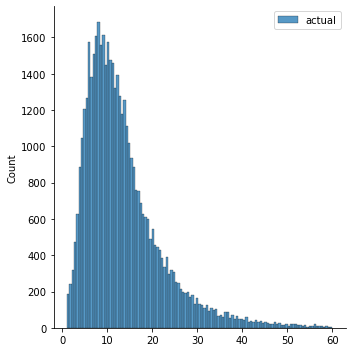

In [37]:
sns.displot(y_predict, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [41]:
mean_squared_error(y_train, y_predict, squared= False)
#Our model is wrong for nine minutes 

8.528512168315896

In [98]:
df_train['PU_DO'] = df_train['PULocationID'].astype(str) + '_' + df_train['DOLocationID'].astype(str)
df_val['PU_DO'] = df_val['PULocationID'].astype(str) + '_' + df_val['DOLocationID'].astype(str)

In [99]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration,PU_DO
0,2,2025-02-01 00:12:15,2025-02-01 00:15:48,N,1.0,166,41,1.0,0.65,6.50,...,0.00,NaN,1.0,10.80,1.0,1.0,0.00,0.00,3.550000,166_41
1,2,2025-01-31 23:57:05,2025-02-01 00:24:24,N,1.0,255,161,1.0,6.57,31.70,...,0.00,NaN,1.0,37.70,2.0,1.0,2.75,0.75,27.316667,255_161
2,2,2025-02-01 00:24:26,2025-02-01 00:49:54,N,1.0,75,182,2.0,8.36,36.60,...,0.00,NaN,1.0,39.10,2.0,1.0,0.00,0.00,25.466667,75_182
3,1,2025-02-01 00:17:15,2025-02-01 00:25:56,N,1.0,97,209,1.0,2.40,12.80,...,0.00,NaN,1.0,22.55,1.0,1.0,2.75,0.75,8.683333,97_209
4,2,2025-02-01 00:17:36,2025-02-01 00:26:36,N,1.0,7,223,1.0,1.31,10.70,...,0.00,NaN,1.0,15.84,1.0,1.0,0.00,0.00,9.000000,7_223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46616,2,2025-02-28 22:35:00,2025-02-28 23:10:00,None,NaN,181,161,NaN,8.23,44.39,...,0.00,NaN,1.0,56.80,NaN,NaN,NaN,0.75,35.000000,181_161
46617,2,2025-02-28 23:40:00,2025-02-28 23:55:00,None,NaN,166,141,NaN,4.10,27.67,...,0.00,NaN,1.0,38.30,NaN,NaN,NaN,0.00,15.000000,166_141
46618,2,2025-02-28 23:34:00,2025-02-28 23:48:00,None,NaN,41,48,NaN,4.09,27.71,...,0.00,NaN,1.0,32.71,NaN,NaN,NaN,0.75,14.000000,41_48
46619,2,2025-02-28 23:52:00,2025-03-01 00:05:00,None,NaN,75,140,NaN,2.25,16.64,...,0.00,NaN,1.0,21.89,NaN,NaN,NaN,0.00,13.000000,75_140


In [101]:
categorical = ['PU_DO'] #'PULocationID','DOLocationID']
numerical = ['trip_distance']

dv  = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [102]:
target = 'duration' 
y_train = df_train[target].values
y_val = df_val[target].values

In [103]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predict = lr.predict(X_val)

In [109]:
mean_squared_error(y_val, y_predict, squared= False)


6.132224457495617

In [110]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [107]:
#Takes more time
lr = Lasso(alpha=0.0001)
lr.fit(X_train, y_train)

y_predict = lr.predict(X_val)
mean_squared_error(y_val, y_predict, squared= False)


6.132224457495617

In [106]:
lr = Ridge(alpha=0.01)
lr.fit(X_train, y_train)

y_predict = lr.predict(X_val)
mean_squared_error(y_val, y_predict, squared= False)


6.398266522680571